# 1. Import


In [1]:
# 1.1 Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state

# 1.2 read data and split it into features and targets
data = pd.read_csv("../data/processedWineData.csv")
# data = data[(data['quality'] > 3) & (data['quality'] < 8)]
X, y = data.loc[:, data.columns != 'quality'], data.loc[:, data.columns == 'quality']

# 2. Check Feature Importance

In [2]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y['quality'])
class_weight_dict = {}
for idx, quanlity in enumerate(np.unique(y)):
    class_weight_dict[quanlity] = class_weight[idx]
print(class_weight_dict)

{3: 34.301587301587304, 4: 4.307641196013289, 5: 0.43379056540649047, 6: 0.3273746402060294, 7: 0.8583344366476897, 8: 4.798667653589933, 9: 185.22857142857143}


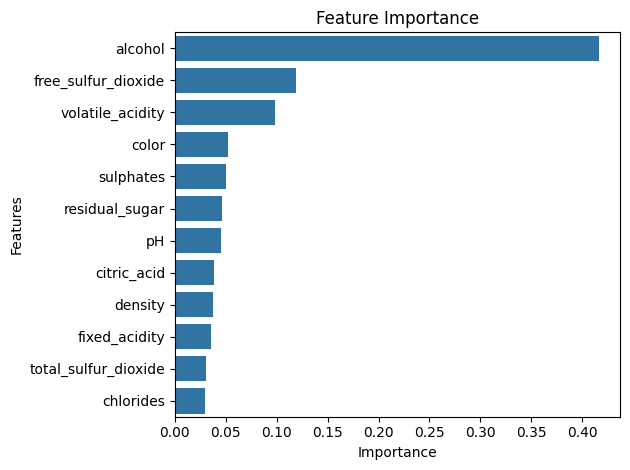

In [3]:
model = xgb.XGBRegressor()
model.fit(X, y, sample_weight=y['quality'].map(class_weight_dict))

# # Plot feature importances
# xgb.plot_importance(model)
# plt.show()

importances = model.feature_importances_

# Plot the features importance using a barplot
feature_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.tight_layout()

# 3 Data Handling

In [4]:
# 3.1 Split data into training, validation and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=9)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=9)

# 3.2 Convert the data into DMatrix, which is a data storage used by XGBoost Algorithm, optimized for both memory efficiency and training speed
D_train = xgb.DMatrix(X_train, label=y_train)
# D_val = xgb.DMatrix(X_val, label=y_val)
D_test = xgb.DMatrix(X_test, label=y_test)

In [8]:
# Data Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.utils import compute_sample_weight
from sklearn.metrics import make_scorer


def weighted_accuracy_eval(y_pred, y_true, **kwargs):
    balanced_class_weights_eval = compute_sample_weight(
        class_weight='balanced',
        y=y_true
    )
    out = accuracy_score(y_pred=np.round(y_pred), y_true=np.round(y_true), sample_weight=balanced_class_weights_eval, **kwargs)
    return out

weighted_accuracy_eval_skl = make_scorer(weighted_accuracy_eval)

y_train_sample_weight = y_train['quality'].map(class_weight_dict)

pipeline = Pipeline(
    [
     ('selector',SelectFromModel(xgb.XGBRegressor(n_estimators=150, random_state=9))),
     ('model', xgb.XGBRegressor(objective='reg:squarederror', nthread=-1))
    ]
)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=9)


grid = GridSearchCV(
    estimator = pipeline,
    param_grid = {
                    'model__n_estimators':np.arange(150,350,20),
                    'model__learning_rate': np.arange(0.06,0.,0.02),
                    'model__max_depth': [4],
                    # 'model__subsample': [0.8],
                    # 'model__colsample_bytree': [0.8],
                    # 'model__gamma': [0.3, 0.5, 0.7],
                    # 'model__alpha': [0.3, 0.5, 0.7],
                    # 'model__lambda': [1.2, 1.3],
                    # 'model__min_child_weight': [5],
                },
    n_jobs=-1,
    scoring=weighted_accuracy_eval_skl,#"neg_mean_squared_error",  
    cv=cv,
    verbose=3,
    error_score='raise'
)


grid.fit(X_train_scaled, y_train, selector__sample_weight=y_train_sample_weight, model__sample_weight=y_train_sample_weight)
best_params = grid.best_params_

Fitting 15 folds for each of 80 candidates, totalling 1200 fits


/Users/heaau/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=15.
  warnings.warn(


[CV 1/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.421 total time=   0.6s
[CV 2/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.435 total time=   0.5s
[CV 5/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.384 total time=   0.6s
[CV 3/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.408 total time=   0.6s
[CV 7/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.390 total time=   0.6s
[CV 4/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.443 total time=   0.6s
[CV 6/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.407 total time=   0.6s
[CV 8/15] END model__learning_rate=0.06, model__max_depth=4, model__n_estimators=150;, score=0.404 total time=   0.6s
[CV 9/15] END model__learning_rate=0.06, model__max_dept

In [25]:
print("best_params: ", best_params)
pipeline.set_params(**best_params)

pipeline.fit(X_train_scaled, y_train)

train_pred_y = pipeline.predict(X_train_scaled)
test_pred_y = pipeline.predict(X_test_scaled)

rounded_train_pred_y = np.round(train_pred_y).astype(int)
rounded_test_y_pred = np.round(test_pred_y).astype(int)

print("Training set Accuracy: {}".format(accuracy_score(y_train, rounded_train_pred_y)))
print("Testing set Accuracy: {}".format(accuracy_score(y_test, rounded_test_y_pred)))

best_params:  {'model__learning_rate': 0.2, 'model__max_depth': 4, 'model__n_estimators': 310}
Training set Accuracy: 0.6216737369841882
Testing set Accuracy: 0.5612952968388589


In [ ]:
# Confusion matrix with seaborn Heatmap
conf_matrix_1=confusion_matrix(y_test, rounded_test_y_pred)
# Seaborn Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap='coolwarm', xticklabels=np.arange(3, 10, 1), yticklabels=np.arange(3, 10, 1))
plt.title('Confusion Matrix (Round off)')
plt.tight_layout()
plt.savefig("confusion_matrix_exact_level.png")

In [43]:
# Accuracy if we count it is one of two closest level 

train_correct = 0
for idx, pred in enumerate(train_pred_y):
    if np.floor(pred)==y_train.iloc[idx]['quality'] or np.ceil(pred)==y_train.iloc[idx]['quality']:
        train_correct += 1

test_correct = 0
for idx, pred in enumerate(test_pred_y):
    if np.floor(pred)==y_test.iloc[idx]['quality'] or np.ceil(pred)==y_test.iloc[idx]['quality']:
        test_correct += 1


print("2 levels Training set Accuracy: {}".format(train_correct/len(y_train)))
print("2 levels Testing set Accuracy: {}".format(test_correct/len(y_test)))

2 levels Training set Accuracy: 0.8997300424219051
2 levels Testing set Accuracy: 0.866615265998458


In [44]:
from sklearn.metrics import r2_score
print(r2_score(y_test, test_pred_y))
print(r2_score(y_test, rounded_test_y_pred))

0.32177438788993906
0.21939965393585292


In [27]:
compare_classes = np.vstack([np.array(X_test['color']).T, np.array(y_test).T, rounded_test_y_pred]).T
df = pd.DataFrame(data=compare_classes, columns=["color", "true_label", "predicted_label"])
df.groupby(["color", "true_label", "predicted_label"]).size()

color  true_label  predicted_label
0      3           4                    1
       4           4                    1
                   5                    4
                   6                    4
       5           4                    2
                   5                  106
                   6                   28
       6           4                    3
                   5                   36
                   6                   72
                   7                    8
       7           5                    2
                   6                   26
                   7                   14
       8           6                    4
                   7                    1
1      3           5                    1
                   6                    3
       4           4                    2
                   5                   17
                   6                   15
       5           4                    1
                   5                  165

In [341]:
compare_classes = np.vstack([np.array(y_test).T, test_pred_y]).T
df2 = pd.DataFrame(data=compare_classes, columns=["true_label", "predicted_label"])
df2

,true_label,predicted_label
0,5.0,5.413635
1,6.0,6.174251
2,7.0,6.217050
3,5.0,5.372993
4,5.0,5.696664
...,...,...
1292,7.0,6.495245
1293,6.0,5.522352
1294,6.0,6.301310
1295,7.0,6.322011


In [70]:
X_train.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color'],
      dtype='object')

In [69]:
grid.best_estimator_['selector'].get_support()

array([False,  True, False, False, False,  True, False, False, False,
       False,  True,  True])

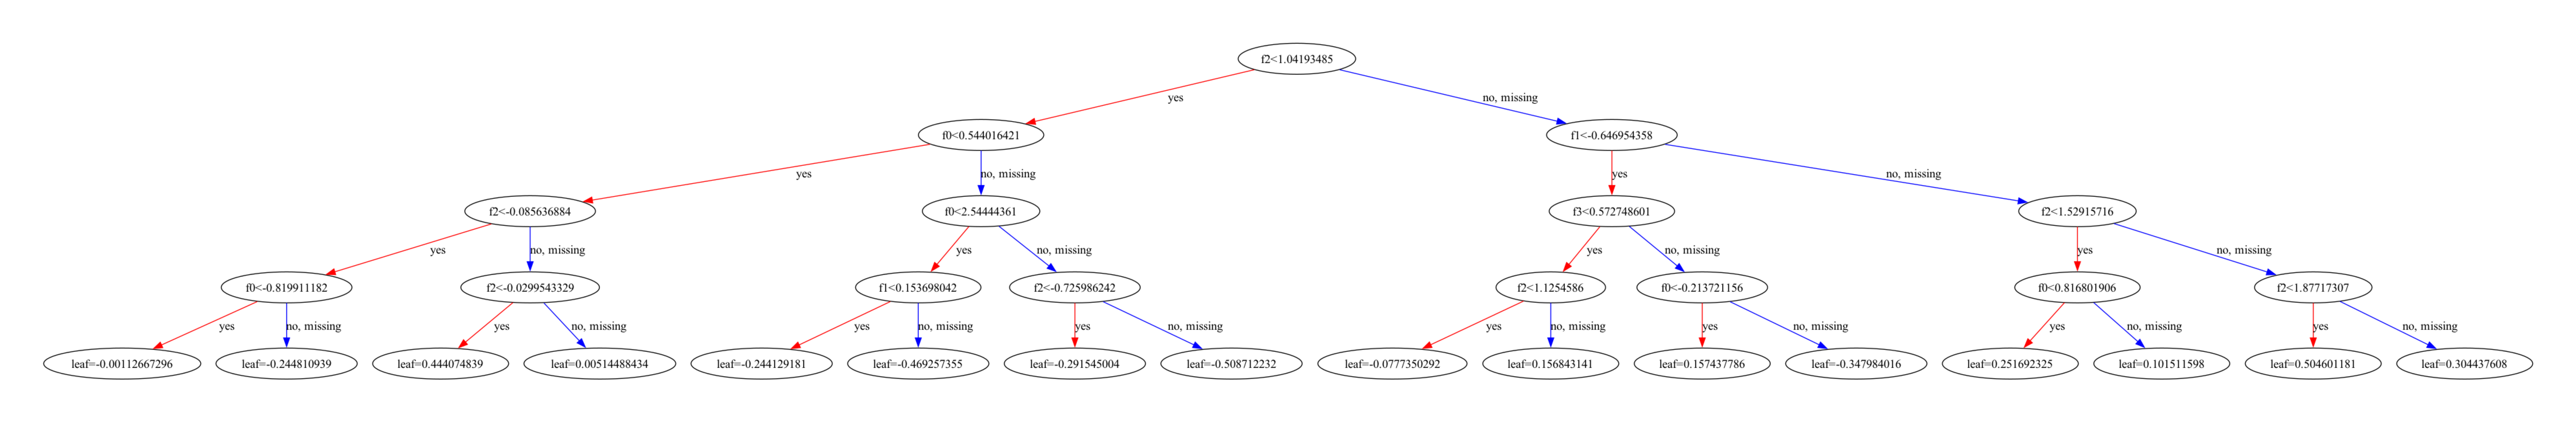

In [75]:
fig, ax = plt.subplots(figsize=(8, 10), dpi=1000)
XGB_pipeline_classifier = grid.best_estimator_.named_steps['model']
xgb.plot_tree(XGB_pipeline_classifier, num_trees=0, ax=ax)
fig.savefig('..XGB_visualizations.png', dpi=1000)
fig.savefig('..XGB_visualizations.pdf', dpi=1000)